In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-db1iibyg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-db1iibyg
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=e6351d820f7bb78d650dafc78f31389f68d34f6f11a92331edbbe13c5fac1c3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-xc3nlbh0/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import requests
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [13]:
# モデルファイルダウンロード
model_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
model_path = "sam_vit_h_4b8939.pth"

response = requests.get(model_url, stream=True)
with open(model_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

In [3]:
# SAMモデルの読み込み
sam_checkpoint = "sam_vit_h_4b8939.pth"  # ダウンロードしたモデルのパス
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# マスク生成器の初期化
predictor = SamPredictor(sam)

In [42]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.65]])
        img[m] = color_mask
    ax.imshow(img)

In [6]:
# 画像の読み込み
image_path = "sample1.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### 点を指定するパターン
りんごの場合

In [ ]:
predictor.set_image(image)

(np.float64(-0.5), np.float64(1535.5), np.float64(1023.5), np.float64(-0.5))

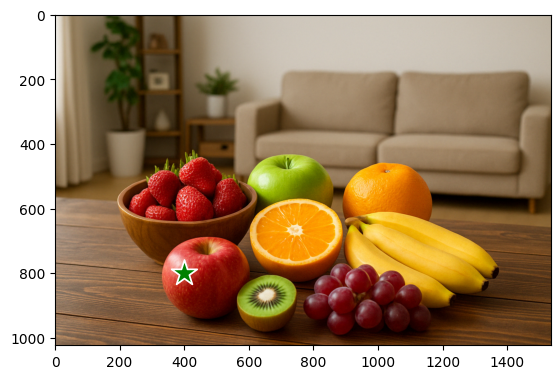

In [56]:
input_point = np.array([[400, 800]])
input_label = np.array([1])

plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')

In [69]:
masks, scores, logits = predictor.predict(
    point_coords=input_point, # ユーザーが指定したポイント
    point_labels=input_label, # そのポイントがオブジェクトなのか背景なのか（1 or 0）
    multimask_output=False, # マスクは1個とする。Trueなら複数返す
)

In [70]:
masks.shape  # (number_of_masks) x H x W

(1, 1024, 1536)

Text(0.5, 1.0, 'Mask 1, Score: 0.984')

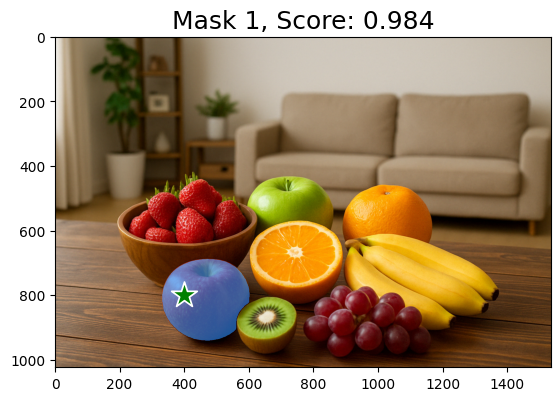

In [59]:
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)

ぶどうの場合

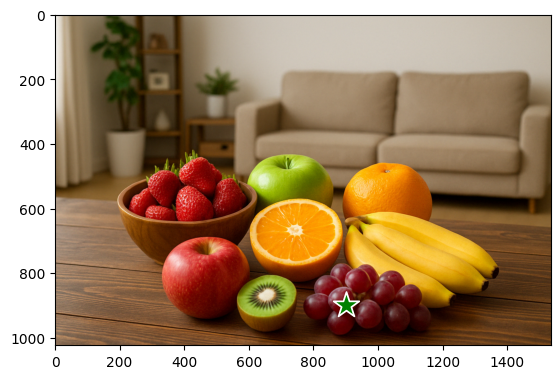

In [71]:
input_point = np.array([[900, 900]])
input_label = np.array([1])

plt.imshow(image)
show_points(input_point, input_label, plt.gca())

In [72]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [74]:
print(masks.shape)
print(scores.shape)

(1, 1024, 1536)
(1,)


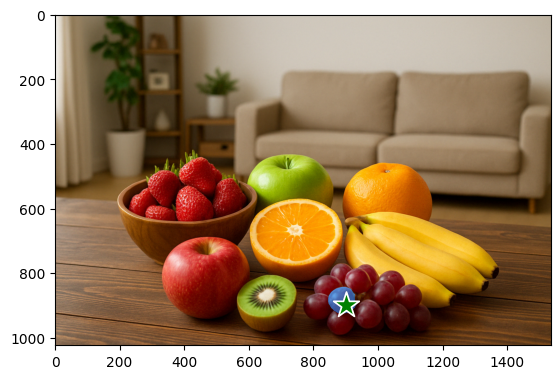

In [64]:
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())

ぶどうの1粒しかわからない → 点の数を多くできる

(np.float64(-0.5), np.float64(1535.5), np.float64(1023.5), np.float64(-0.5))

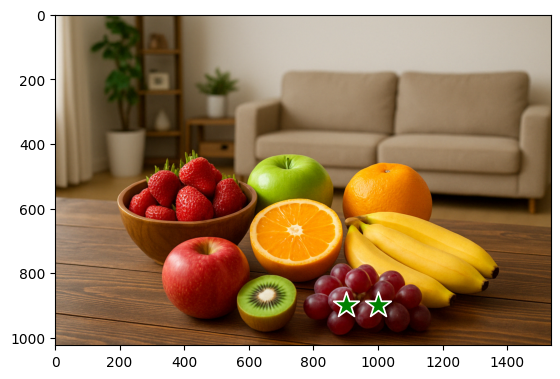

In [65]:
input_point = np.array([[900, 900],[1000, 900]])
input_label = np.array([1, 1])

plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')

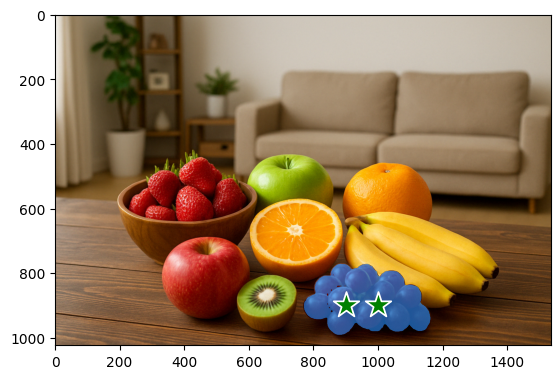

In [ ]:
# mask_input = logits[np.argmax(scores), :, :]  # multimask_output=Trueのとき

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=logits[0][None, :, :]  , # 先ほどの情報の再利用
    multimask_output=False,
)

plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())

### 自動パターン

In [25]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [27]:
print(len(masks))
print(masks[0].keys())

119
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


(np.float64(-0.5), np.float64(1535.5), np.float64(1023.5), np.float64(-0.5))

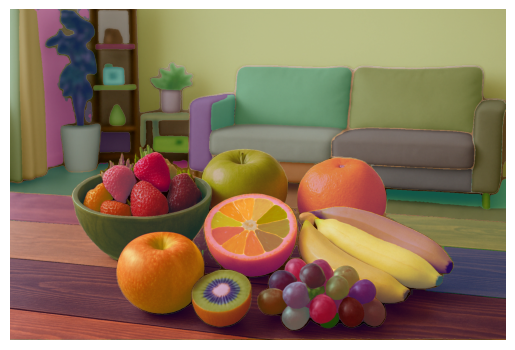

In [29]:
plt.imshow(image)
show_anns(masks)
plt.axis('off')

#### オプション追加

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8,
    pred_iou_thresh=0.9,
    min_mask_region_area=100,
)

masks2 = mask_generator_2.generate(image)
print(len(masks2))

45


(np.float64(-0.5), np.float64(1535.5), np.float64(1023.5), np.float64(-0.5))

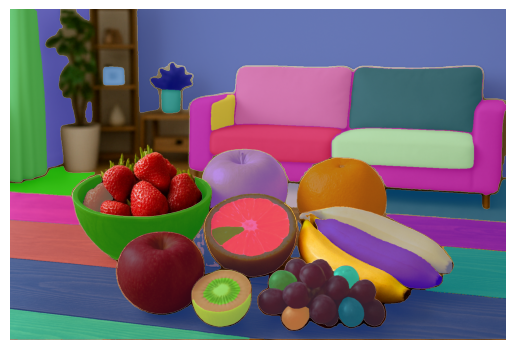

In [43]:
plt.imshow(image)
show_anns(masks2)
plt.axis('off')